In [1]:
# coding: utf-8
import os

import pandas as pd
import numpy as np
import scipy
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.linear_model import ElasticNet, ElasticNetCV

from mydatools.plot import plot_grid_search_result

% matplotlib inline

## Config

In [2]:
# trn_path = './data/input/train.csv'
tst_path = './data/input/test.csv'
id_col = 'ID'
label_col = 'item_cnt_month'

submission_path = './data/output/submission/submission.csv'
output_id_col = id_col
output_label_col = label_col

## Load Data

In [3]:
item_cate_df = pd.read_csv('./data/input/item_categories.csv')
item_df = pd.read_csv('./data/input/items.csv')
sales_df = pd.read_csv('./data/input/sales_train.csv')
shop_df = pd.read_csv('./data/input/shops.csv')

In [4]:
sales_df['revenue'] = sales_df['item_price'] * sales_df['item_cnt_day']
trn_df = sales_df.groupby(['shop_id', 'item_id', 'date_block_num'])['item_cnt_day'].sum().reset_index()
trn_df = trn_df.rename(columns={'item_cnt_day': 'item_cnt_month'})
trn_df['ID'] = 0
trn_df['ds_type'] = 'trn'

tst_df = pd.read_csv(tst_path)
tst_df['date_block_num'] = 34
tst_df['item_cnt_month'] = 0
tst_df['ds_type'] = 'tst'

full_df = pd.concat([trn_df, tst_df])
full_df.head()

,ID,date_block_num,ds_type,item_cnt_month,item_id,shop_id
0,0,1,trn,31.0,30,0
1,0,1,trn,11.0,31,0
2,0,0,trn,6.0,32,0
3,0,1,trn,10.0,32,0
4,0,0,trn,3.0,33,0


In [5]:
# dataset type
is_trn = full_df['ds_type'] == 'trn'
is_tst = full_df['ds_type'] == 'tst'

## Features

In [6]:
feature_columns = []

def add_features(features):
    if not isinstance(features, list):
        features = [features]
    global feature_columns
    feature_columns.extend([f for f in features if f not in feature_columns])
    
def remove_features(features):
    if not isinstance(features, list):
        features = [features]
    global feature_columns
    feature_columns = [f for f in feature_columns if f not in features]

**shop_id, item_id**

In [7]:
# add_features(['shop_id', 'item_id'])

**datetime info**

In [8]:
full_df['dt_year'] = full_df['date_block_num'] // 12 + 2013
full_df['dt_month'] = full_df['date_block_num'] % 12 + 1
add_features(['dt_year', 'dt_month'])

**aggragation data**

In [9]:
def get_aggragation_feature(df, groupby_cols, agg_col):
    gb = df[df['ds_type'] == 'trn'].groupby(groupby_cols)[agg_col]
    fname_fmt = '-'.join(groupby_cols+[agg_col]) + ':%s'
    agg_df = pd.DataFrame({
            fname_fmt%'mean': gb.mean(),
            fname_fmt%'median': gb.median(),
            fname_fmt%'max': gb.max(),
            fname_fmt%'min': gb.min(),
        })
    new_df = df.join(agg_df, on=groupby_cols).fillna(0)
    return new_df, agg_df.columns.tolist()

In [10]:
groupby_cols_list = [
    ['shop_id', 'item_id'],
    ['shop_id'],
    ['item_id'],
    ['date_block_num'],
    ['dt_month'],
]
for groupby_cols in groupby_cols_list:
    full_df, new_feats = get_aggragation_feature(full_df, groupby_cols, 'item_cnt_month')
    add_features(new_feats)

## ElasticNet

In [11]:
trn_df = full_df[is_trn]
tst_df = full_df[is_tst]

X = trn_df[feature_columns]
y = trn_df[label_col]
# X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

X_tst = tst_df[feature_columns]

In [12]:
# scale
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X_tst = scaler.transform(X_tst)

In [13]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
#     'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
    'l1_ratio': [0.5],
}

clf = ElasticNet()
def rmse(y, y_pred):
    return np.sqrt(metrics.mean_squared_error(y, y_pred))
scoring = metrics.make_scorer(rmse, greater_is_better=False)
model = GridSearchCV(clf, param_grid, scoring=scoring, cv=5, verbose=1)

In [14]:
model.fit(X, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  5.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'l1_ratio': [0.5], 'alpha': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(rmse, greater_is_better=False), verbose=1)

Best params: {'l1_ratio': 0.5, 'alpha': 0.001}
Best score: -5.47889882954044


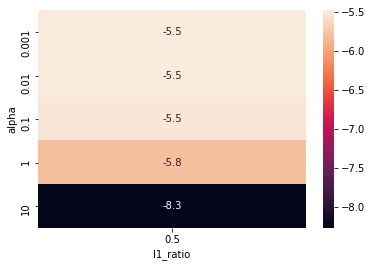

In [15]:
plot_grid_search_result(model)

## Predict

In [16]:
res_df = pd.DataFrame(model.predict(X_tst).clip(0,20), columns=[output_label_col])
res_df[output_id_col] = tst_df[output_id_col].values
res_df[[output_id_col, output_label_col]].to_csv(submission_path, index=False)